Thank you for taking some time to check out this notebook! This analysis uses a subset of the [2019a dataset](https://www.rxrx.ai/rxrx19a) shared by Recursion. This subset only includes the HRCE cell data. I was inspired to tinker with this data after reading Recursion's [publication on this dataset](https://www.biorxiv.org/lookup/doi/10.1101/2020.04.21.054387). 

My goal was not to perfectly replicate the published work, but to use it as an initial guide and implement my own approach based on my current knowlege and understanding of phenomics HTS assays. This is my first time working with this type of data - it's a fun learning experience and work in progress.

I have not yet calculated hit scores, but my analysis so far indicates that Remdesivir has good efficacy without off-disease effects, Ritonavir has essentially no effect, and Lopinavir may have a moderate effect. Pacritinib has moderate effect at moderate doses and off-disease effects at high doses. My Z-factor is not as good as that published by Recursion (0.35 vs. 0.43). I haven't yet figured out why there is so much variance in the negative controls. My normalization methods could still be improved - perhaps using an empirical Bayes approach where the prior is a mixture distribution between the positive and negative controls (either it "looks" diseased, or it "looks" healthy), somewhat similar to this [article](https://academic.oup.com/nar/article/36/14/4667/2410417?login=false). Alternatively, there may be an approach that allows me to take advantage of the fact that the same molecules are tested at different concentrations (linear mixed model?).

Interestingly, my current approach seems to produce a bit better repeatability between the two HRCE experiments, as indicated by correlation coefficients and mean-difference plots compared to the results shared by Recursion.

# Import Libraries and Data

In [1]:
# Import libraries
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product

from scipy import spatial
from scipy import stats
from scipy.optimize import curve_fit
import statsmodels.api as sm
from statsmodels.graphics import tsaplots

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.manifold import TSNE


# Load in the dataset, which is subset of the full dataset that only contains HRCE data and treatments that were shared between the 2 experiments
metadata = pd.read_csv('/Volumes/GoogleDrive/My Drive/Colab Notebooks/Recursion COVID/metadata.csv')
features = pd.read_csv('/Volumes/GoogleDrive/My Drive/Colab Notebooks/Recursion COVID/embeddings.csv')

# Data Overview

## Overview of original metadata

In [4]:
metadata.head()

,site_id,well_id,cell_type,experiment,plate,well,site,disease_condition,treatment,treatment_conc,SMILES
0,HRCE-1_1_AA02_1,HRCE-1_1_AA02,HRCE,HRCE-1,1,AA02,1,Active SARS-CoV-2,Flubendazole,0.1,COC(=O)NC1=NC2=C(N1)C=C(C=C2)C(=O)C1=CC=C(F)C=...
1,HRCE-1_1_AA02_2,HRCE-1_1_AA02,HRCE,HRCE-1,1,AA02,2,Active SARS-CoV-2,Flubendazole,0.1,COC(=O)NC1=NC2=C(N1)C=C(C=C2)C(=O)C1=CC=C(F)C=...
2,HRCE-1_1_AA02_3,HRCE-1_1_AA02,HRCE,HRCE-1,1,AA02,3,Active SARS-CoV-2,Flubendazole,0.1,COC(=O)NC1=NC2=C(N1)C=C(C=C2)C(=O)C1=CC=C(F)C=...
3,HRCE-1_1_AA02_4,HRCE-1_1_AA02,HRCE,HRCE-1,1,AA02,4,Active SARS-CoV-2,Flubendazole,0.1,COC(=O)NC1=NC2=C(N1)C=C(C=C2)C(=O)C1=CC=C(F)C=...
4,HRCE-1_1_AA03_1,HRCE-1_1_AA03,HRCE,HRCE-1,1,AA03,1,Active SARS-CoV-2,acetylcysteine,1.0,"CC(=O)N[C@H](CS)C(O)=O |a:4,r|"


## Overview of original feature data

In [5]:
features.head()

,site_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_1014,feature_1015,feature_1016,feature_1017,feature_1018,feature_1019,feature_1020,feature_1021,feature_1022,feature_1023
0,HRCE-1_10_AA02_1,2.355969,-0.058361,-0.169764,-0.316499,-0.891334,0.581174,-0.284587,-0.279198,-0.146575,...,0.391186,0.786199,-1.739626,-1.317543,-1.208275,-0.507439,-0.317298,0.285018,-0.091285,-1.553895
1,HRCE-1_10_AA02_2,2.325652,-0.202519,-0.296017,-0.481136,-0.641461,0.702847,0.334191,-0.077498,-0.314538,...,0.638674,1.051621,-1.355659,-1.285210,-1.341911,-0.271349,-0.157707,0.081128,-0.447174,-1.614872
2,HRCE-1_10_AA02_3,2.207082,-0.379794,-0.365562,-0.196667,-0.799039,0.735813,0.081227,-0.393452,0.066324,...,0.552127,0.775428,-1.616731,-0.868382,-1.334486,-0.774456,-0.363250,0.161023,-0.066745,-1.325545
3,HRCE-1_10_AA02_4,2.452741,0.050658,-0.444642,-0.309758,-0.724900,0.658327,-0.128331,-0.164759,0.279105,...,0.689145,1.167066,-1.275786,-2.088455,-1.231964,-0.364454,-0.135066,0.493010,-0.544680,-1.290150
4,HRCE-1_10_AA03_1,2.106868,0.032095,-0.175542,-0.808618,-0.806217,0.721340,-0.213196,-0.187649,-0.070294,...,0.385696,0.503924,-1.192554,-1.123965,-1.323457,-0.359761,-0.100340,0.185773,-0.394267,-1.712760


## Value counts for each cell type, experiment, and disease condition

In [6]:
metadata[['cell_type', 'experiment', 'disease_condition']].value_counts()

cell_type  experiment  disease_condition        
HRCE       HRCE-2      Active SARS-CoV-2            132776
           HRCE-1      Active SARS-CoV-2            127920
VERO       VERO-1      Active SARS-CoV-2              9840
           VERO-2      Active SARS-CoV-2              9840
HRCE       HRCE-2      Mock                           4320
                       UV Inactivated SARS-CoV-2      4320
           HRCE-1      Mock                           4160
                       UV Inactivated SARS-CoV-2      4160
VERO       VERO-1      Mock                            320
                       UV Inactivated SARS-CoV-2       320
           VERO-2      Mock                            320
                       UV Inactivated SARS-CoV-2       320
dtype: int64

# Initial Data Handling


In this section, I do some simple data preparation:
- Drop VERO data to focus on HRCE cell data only
- Reduce the measurements to 1 measurement per well by averaging over the 4 sites in each well
- Rename the disease condition to simpler names (i.e., Active vs. Inactive)
- Extract row and column numbers from the well ID for 2D localization on a given plate
- Create a new metadata column "groups" to define the positive and negative control groups vs treated

In [7]:
# Just HRCE
metadata = metadata.loc[metadata.cell_type == 'HRCE',:].set_index('site_id') 
features = features.set_index('site_id').loc[metadata.index]

# Tidy the metadata; average features over the sites in each well to get 1 value per well
features = features.join(metadata.well_id)
metadata = metadata.groupby('well_id').first()
features = features.groupby('well_id').mean()

# Simplify the metadata and make it a bit easier to work with
metadata.disease_condition = metadata.disease_condition.replace({'UV Inactivated SARS-CoV-2': 'Inactive', 'Active SARS-CoV-2': 'Active'})
metadata.disease_condition.fillna('None', inplace=True)
metadata.treatment.fillna('None', inplace=True)
metadata.treatment_conc.fillna('None', inplace=True)
metadata.drop(['SMILES', 'site', 'cell_type'], axis=1, inplace=True)

# Decompose the well number into column and row labels
metadata = metadata.join(metadata['well'].str.extract('(?P<well_row>\D+)(?P<well_col>\d+)'))

# Relabel the rows with numbers instead of letters
rows = list(string.ascii_uppercase) + ['AA', 'AB', 'AC', 'AD', 'AE', 'AF']
row_dict = dict(zip(rows, range(1, len(rows)+1)))
metadata.well_row.replace(row_dict, inplace=True)
metadata[['well_col', 'well_row']] = metadata[['well_col', 'well_row']].astype(int)
metadata.drop(['well'], axis=1, inplace=True)

# Define Groups
metadata['group'] = np.select(
    [
    ((metadata.disease_condition=='Active') & (metadata.treatment=='None')),
    ((metadata.disease_condition=='Mock')),
    ((metadata.disease_condition=='Active') & (metadata.treatment!='None')),
    ((metadata.disease_condition=='Inactive')),
    ((metadata.disease_condition=='None')),
    ], 
    [
    'pos_ctrl',
    'neg_ctrl',
    'treated',
    'neg_ctrl_2',
    'none_ctrl'
    ], default=np.nan)

# Save groups based on index for easier slicing later
pos_ctrl = metadata[(metadata.disease_condition=='Active') & (metadata.treatment=='None')].index
neg_ctrl = metadata[(metadata.disease_condition=='Mock') & (metadata.treatment=='None')].index
all_active = metadata[metadata.disease_condition=='Active'].index
main_ctrls = pos_ctrl.union(neg_ctrl)
neg_ctrl_2 = metadata[(metadata.disease_condition=='Inactive') & (metadata.treatment=='None')].index

# Exploratory Data Analysis

## Check if there is correlation between features
- Randomly selected 100 features to look at
- Positive and negative correlations are evident among features, suggesting the feature space can be reduced effectively with PCA

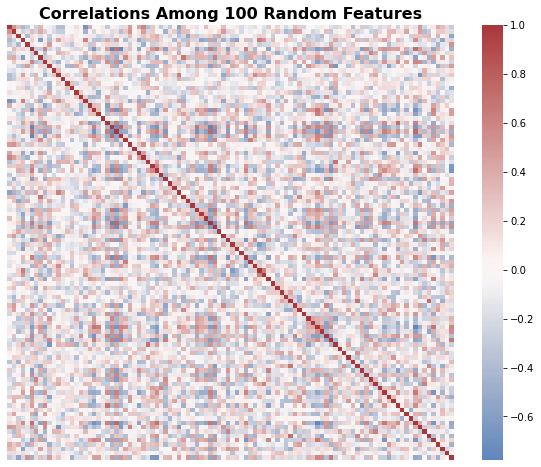

In [46]:
plt.figure(figsize=(10,8));
sns.heatmap(features.sample(n=100, random_state=0, axis=1).corr(), cmap='vlag', center=0);
plt.title('Correlations Among 100 Random Features', fontdict={'weight':'bold', 'size':16});
plt.axis('off');

## Visualize the distribution of controls on the plates
- It looks like the negative controls (cyan, magenta, blue) are not randomized within each plate and the positive controls (red) are never in the same column as negative controls.
- Positive controls (red) are randomized among treated wells (green)

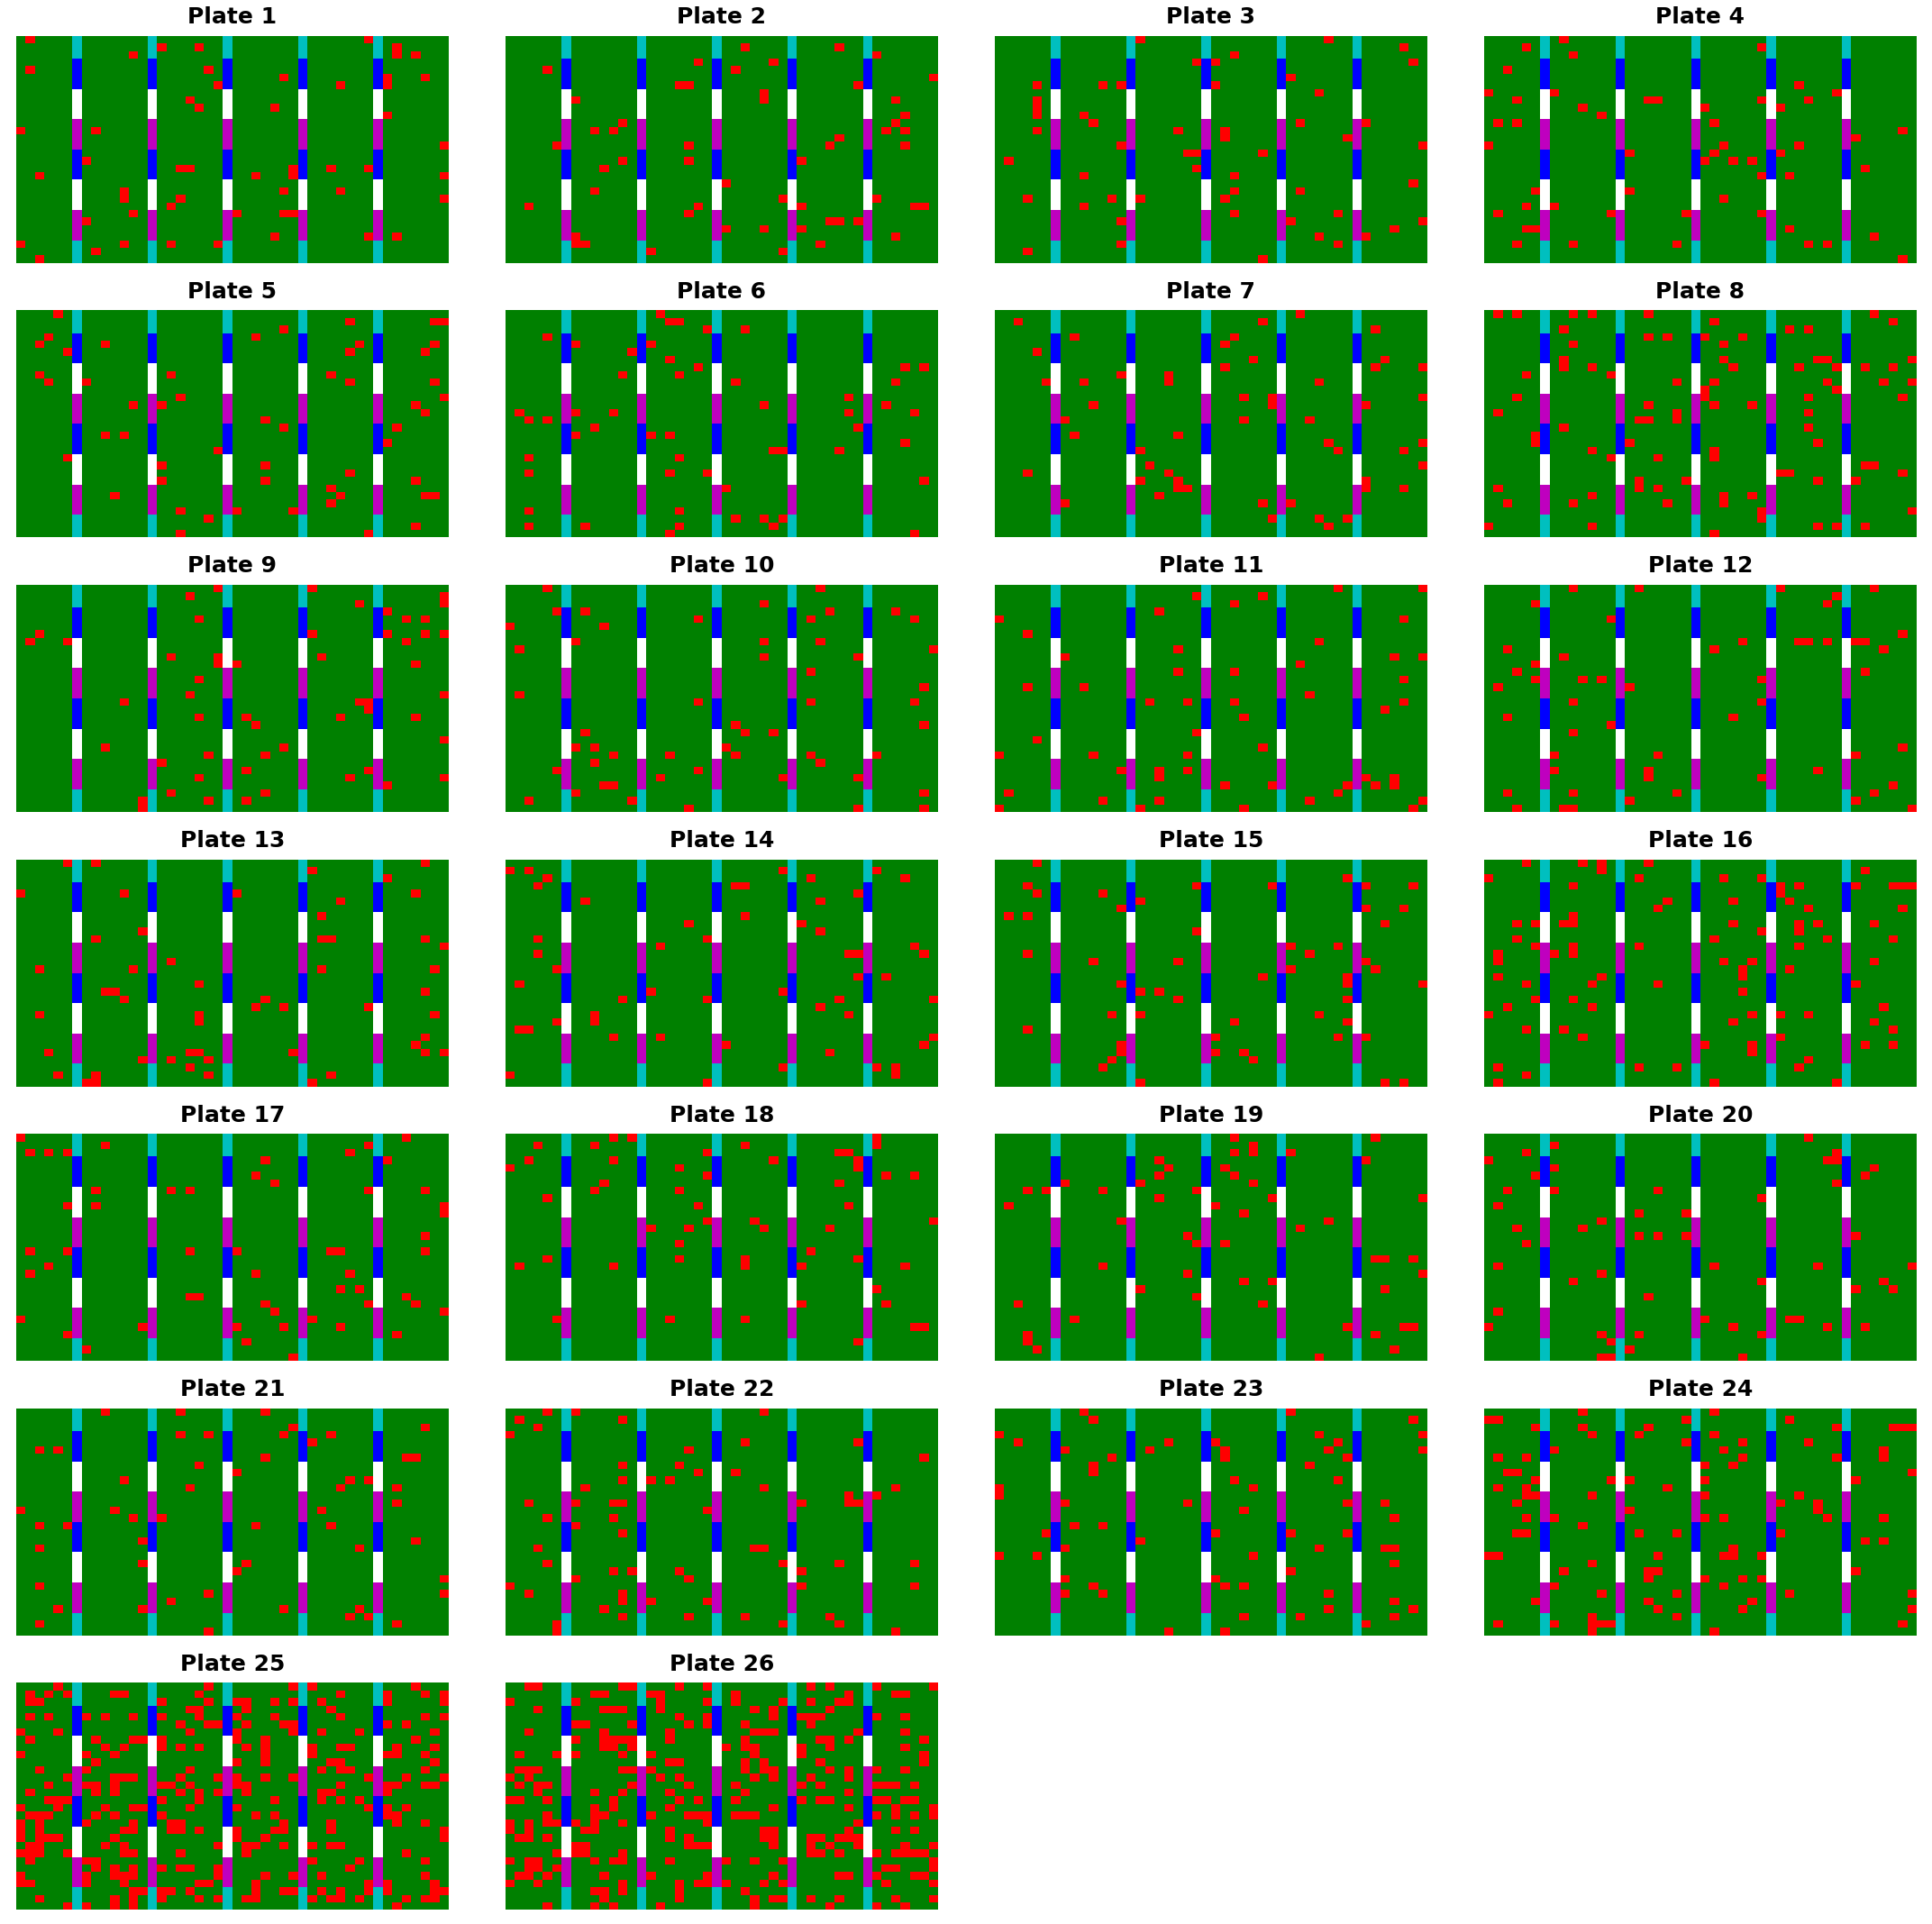

In [47]:
data = metadata[metadata.experiment=='HRCE-1']

_, ax = plt.subplots(7,4, figsize=(30,30))
for ii, curr_ax in enumerate(ax.reshape(-1)):
  ii += 1
  platedata = pd.DataFrame(np.zeros([32,48]), index=range(1,33), columns=range(1,49))
  plt.sca(curr_ax)
  plt.axis('off')
  
  if ii in data.plate.unique():
    currdata = data.loc[data.plate == ii].pivot(index='well_row', columns='well_col', values='group').replace({'pos_ctrl':2, 'treated':1, np.nan:0, 'neg_ctrl':-1, 'neg_ctrl_2':-2, 'none_ctrl':-3})
    platedata.loc[currdata.index, currdata.columns] = currdata
    sns.heatmap(platedata, cmap=['c', 'm', 'b', 'w', 'g', 'r'], cbar=False, xticklabels=True, yticklabels=True)
    plt.title('Plate {}'.format(ii), fontdict={'weight': 'bold', 'size':25});    
    plt.tight_layout()


## Examine the control distributions for a couple of features
- Generally, distributions within each plate are approximately bell-shaped (normal) with a few exceptions, suggesting there may be differences or systematic bias between and/or within plates

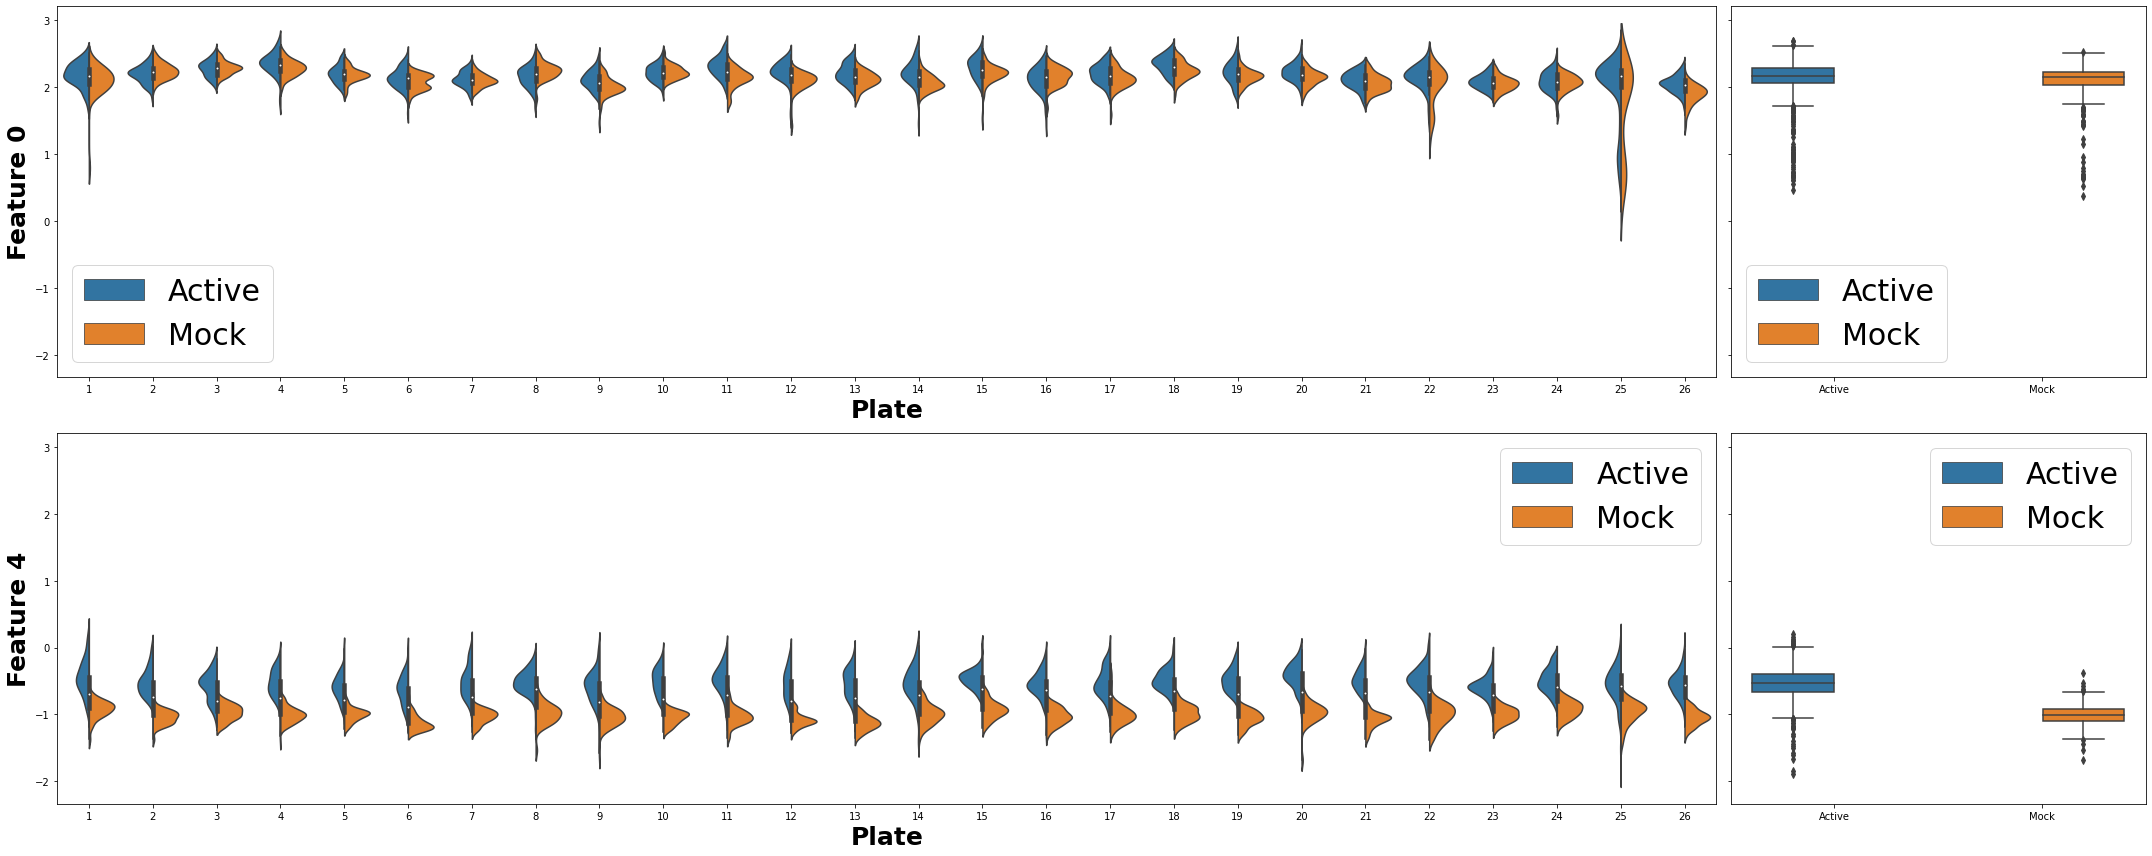

In [61]:
data=metadata.loc[main_ctrls]
data=data[data.experiment=='HRCE-1']

_, ax = plt.subplots(2,2, figsize=(30,12), gridspec_kw={'width_ratios': [4, 1]}, sharey=True)

labels = ['Feature 0', 'Feature 4']

for ii, feature in enumerate(['feature_0', 'feature_4']):

    plt.sca(ax[ii,0])
    sns.violinplot(x='plate', y=feature, hue='disease_condition', split=True, data=data.join(features))
    plt.ylabel(labels[ii], fontdict={'weight': 'bold', 'size':25});
    plt.xlabel('Plate', fontdict={'weight': 'bold', 'size':25});
    plt.legend(prop={'size': 30});

    plt.sca(ax[ii,1])
    sns.boxplot(x='disease_condition', y=feature, hue='disease_condition', data=data.join(features))
    plt.legend(prop={'size': 30});
    plt.ylabel('')
    plt.xlabel('')

plt.tight_layout()

## Visualize feature space of controls in 2D using t-SNE
- It looks like there is some clustering related to the plate and there are certainly batch effects between experiments
- Some of the "Active" positive control wells seem to cluster with the Mock negative control wells - perhaps the viral infection was not successful in those wells? Anomalies to be removed?

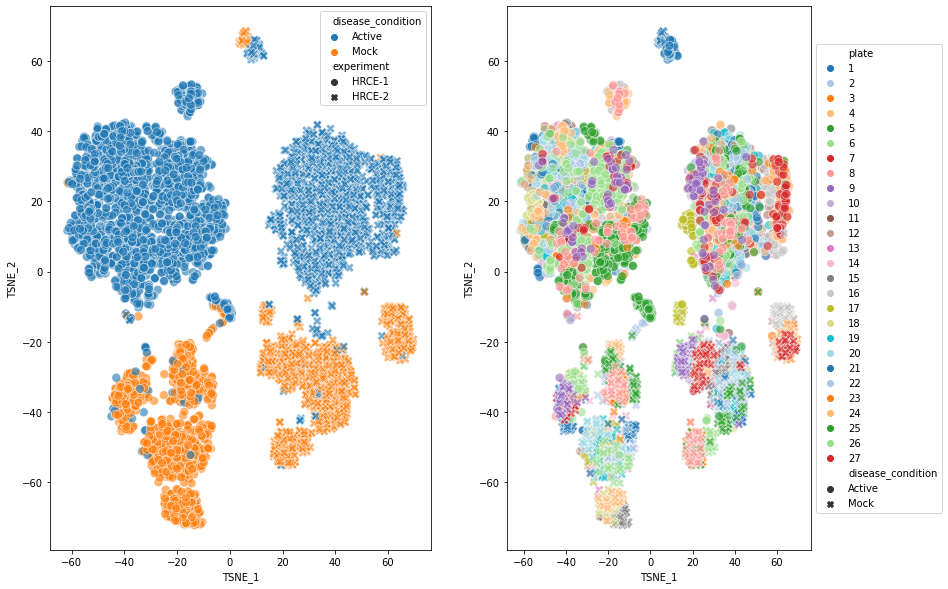

In [15]:
tsne = TSNE(init='pca')
tsne_f = tsne.fit_transform(features.loc[main_ctrls])
tsne_f = pd.DataFrame(tsne_f, index=main_ctrls, columns=['TSNE_1', 'TSNE_2'])

_, ax = plt.subplots(1,2, figsize=(15,10))

plt.sca(ax[0])
sns.scatterplot(x='TSNE_1', y='TSNE_2', hue='disease_condition', style='experiment', s=80, alpha=0.6, data=tsne_f.join(metadata))

plt.sca(ax[1])
sns.scatterplot(x='TSNE_1', y='TSNE_2', hue='plate', palette='tab20', style='disease_condition', s=80, alpha=0.6, data=tsne_f.join(metadata))
box = ax[1].get_position();
ax[1].set_position([box.x0, box.y0, box.width * 0.8, box.height]);
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5));

## Examine autocorrelations by well row and column
- There are some significant autocorrelations for the positive controls and All Active wells (positive controls plus treated wells) that suggest there may be spatial bias (rows / columns) on the plate

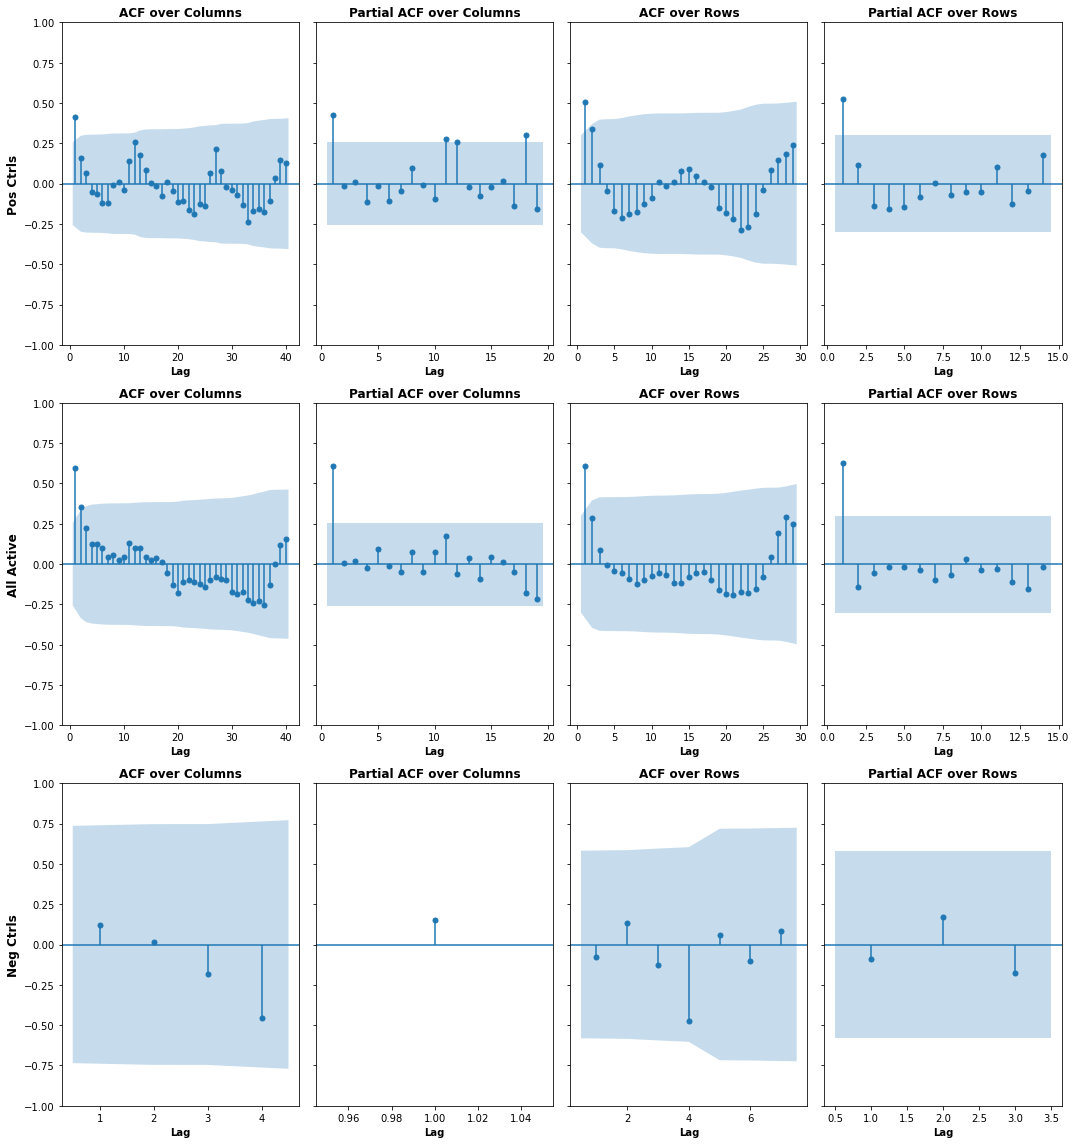

In [72]:
feat = 'feature_0'
exp = 'HRCE-1'

groups = [pos_ctrl, all_active, neg_ctrl]
group_labels = ['Pos Ctrls', 'All Active', 'Neg Ctrls']
directions = ['well_col', 'well_row']
direction_labels = ['Columns', 'Rows']

fig, ax = plt.subplots(len(groups), len(directions)*2, figsize=(len(groups)*5, len(directions)*8), sharey=True)

for ii, (group, group_lab) in enumerate(zip(groups, group_labels)):
    for jj, (direction, dir_lab) in enumerate(zip(directions, direction_labels)):
                     
        data = features.loc[(metadata.experiment==exp)]
        data = data.loc[data.index.intersection(group)]
        data = data.join(metadata[direction]).groupby(direction).median()
        
        tsaplots.plot_acf(data[feat], 
                          zero=False, 
                          lags=data.shape[0]-1,
                          ax = ax[ii, jj*2],
                          alpha=0.1);
        plt.sca(ax[ii, jj*2])
        plt.ylim(-1,1);
        plt.xlabel('Lag', fontdict={'weight':'bold'})
        plt.title('ACF over ' + dir_lab, fontdict={'weight':'bold'})
        
        tsaplots.plot_pacf(data[feat], 
                          zero=False, 
                          lags=data.shape[0]//2-1,
                          ax = ax[ii, jj*2+1],
                          alpha=0.1);
        plt.sca(ax[ii, jj*2+1])
        plt.ylim(-1,1);
        plt.title('Partial ACF over ' + dir_lab, fontdict={'weight':'bold'})
        plt.xlabel('Lag', fontdict={'weight':'bold'})
        
    ax[ii,0].set_ylabel(group_lab, size='large', weight='bold')

fig.tight_layout()

## Plot the distribution of feature values within each group
- One specific treatment (Pacritinib) was selected to represent a treated sample
- The 1024 features seem to be normally distributed with mean~0, within groups or randomly selected samples. The distributions may vary a bit between groups (e.g., Pacritinib at conc=10 seems to have a tigheter distribution than pos and neg ctrl). Standardizing these distributions with a quantile transform within each group could be appropriate to help reduce variance - using the sklearn version of QN would also normalize the magnitudes of the vectors, which means we would be focusing more on differences in their direction (cosine similarity) than on euclidean distances

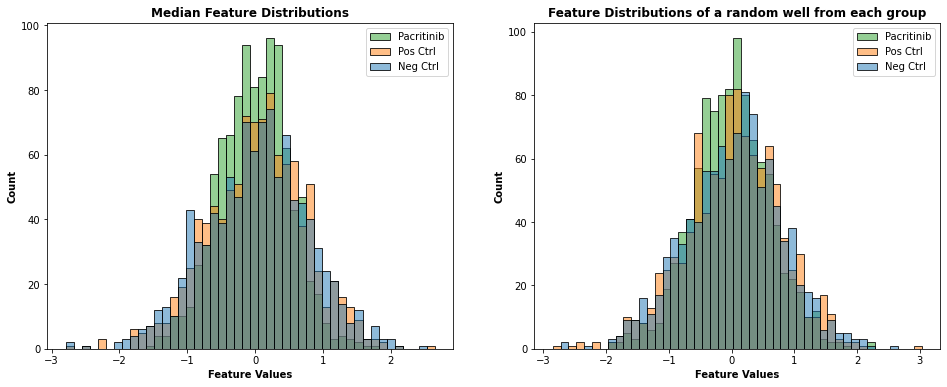

In [74]:
data = features.join(metadata.group).loc[metadata.experiment=='HRCE-1'].groupby('group').median()
data.drop(['neg_ctrl_2', 'none_ctrl'], axis=0, inplace=True)
idx = (metadata.treatment=='Pacritinib') & (metadata.treatment_conc==10) # instead of a random treated, use one with known difference from ctrls
data.loc['treated',:] = features[idx].median()
data = data.reset_index().melt(id_vars='group', value_vars=features.columns)
_, ax = plt.subplots(1,2, figsize=(16,6))
plt.sca(ax[0])
sns.histplot(data, x='value', hue='group', alpha=0.5);
plt.title('Median Feature Distributions', weight='bold');
plt.ylabel('Count', fontdict={'weight':'bold'});
plt.xlabel('Feature Values', fontdict={'weight':'bold'});
plt.legend(['Pacritinib', 'Pos Ctrl', 'Neg Ctrl']);

data2 = features.join(metadata.group).loc[metadata.experiment=='HRCE-1'].groupby('group').first()
data2.drop(['neg_ctrl_2', 'none_ctrl'], axis=0, inplace=True)
data2.loc['treated',:] = features[idx].iloc[0,:]
data2 = data2.reset_index().melt(id_vars='group', value_vars=features.columns)
plt.sca(ax[1])
sns.histplot(data2, x='value', hue='group', alpha=0.5);
plt.title('Feature Distributions of a random well from each group', weight='bold');
plt.xlabel('Feature Values', fontdict={'weight':'bold'});
plt.ylabel('Count', fontdict={'weight':'bold'});
plt.legend(['Pacritinib', 'Pos Ctrl', 'Neg Ctrl']);

# Normalization

## Plate Normalization
- Robust normalization of each plate based on the negative control 

In [132]:
# Normalize each plate based on the negative control data

features_norm = features.copy()

for exp in metadata.experiment.unique(): # For each experiment
  for plate in metadata[metadata.experiment==exp].plate.unique(): # For each microplate in the experiment

    curr = features_norm[(metadata.plate == plate) & (metadata.experiment == exp)] # current plate in the experiment

    # Robust normalization based on negative controls within the plate
    idx_mask = curr.index.intersection(neg_ctrl)
    med_neg = curr.loc[idx_mask].median() # Median of negative control on the plate    
    mad_neg = curr.loc[idx_mask].mad() # MAD of neg ctrl on plate    
    features_norm.loc[curr.index] = curr.apply(lambda x: (x - med_neg) / mad_neg, axis=1) # Robust normalization based on the median and MAD of the negative conrol group within each plate, on each feature

## Visualize the features on a plate format
- The "All Active" (right) plot certainly looks like there are some edge effects at least

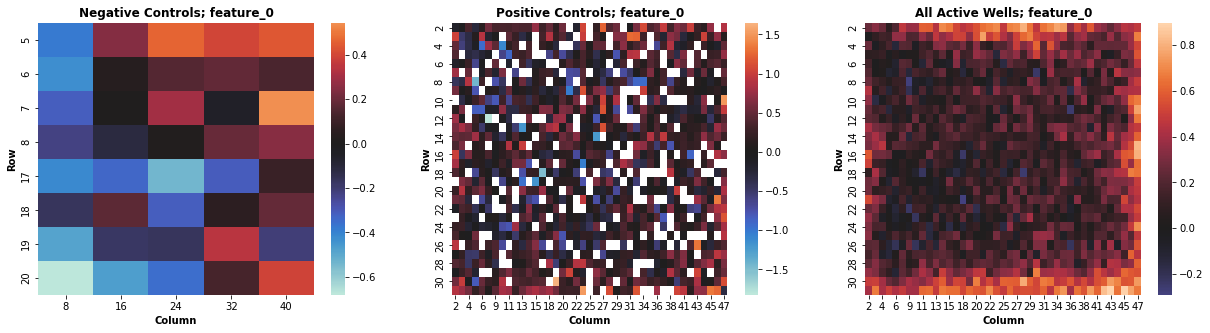

In [162]:
# Visualize the feature median on the plate
exp = 'HRCE-1'
feat = 'feature_0'

data_neg = features_norm.join(metadata).loc[neg_ctrl]
data_neg = data_neg[data_neg.experiment==exp].groupby(['well_row', 'well_col'])[feat].median().reset_index().pivot(index='well_row', columns='well_col', values=feat)
data_pos = features_norm.join(metadata).loc[pos_ctrl]
data_pos = data_pos[data_pos.experiment==exp].groupby(['well_row', 'well_col'])[feat].median().reset_index().pivot(index='well_row', columns='well_col', values=feat)
data_allactive = features_norm.join(metadata).loc[all_active]
data_allactive = data_allactive[data_allactive.experiment==exp].groupby(['well_row', 'well_col'])[feat].median().reset_index().pivot(index='well_row', columns='well_col', values=feat)

_, ax = plt.subplots(1,3, figsize=(21,5))
plt.sca(ax[0])
sns.heatmap(data_neg, center=0)
plt.title('Negative Controls; feature_0', fontdict={'weight': 'bold'});
plt.xlabel('Column', fontdict={'weight': 'bold'});
plt.ylabel('Row', fontdict={'weight': 'bold'});

plt.sca(ax[1])
sns.heatmap(data_pos, center=0)
plt.title('Positive Controls; feature_0', fontdict={'weight': 'bold'});
plt.xlabel('Column', fontdict={'weight': 'bold'});
plt.ylabel('Row', fontdict={'weight': 'bold'});

plt.sca(ax[2])
sns.heatmap(data_allactive, center=0)
plt.title('All Active Wells; feature_0', fontdict={'weight': 'bold'});
plt.xlabel('Column', fontdict={'weight': 'bold'});
plt.ylabel('Row', fontdict={'weight': 'bold'});

## Visualize the features across rows and columns for all Active wells
- Across columns (left), there are clearly edge effects
- Edge effects also seem to exist across rows, but there is also greater oscillating variation across the plate

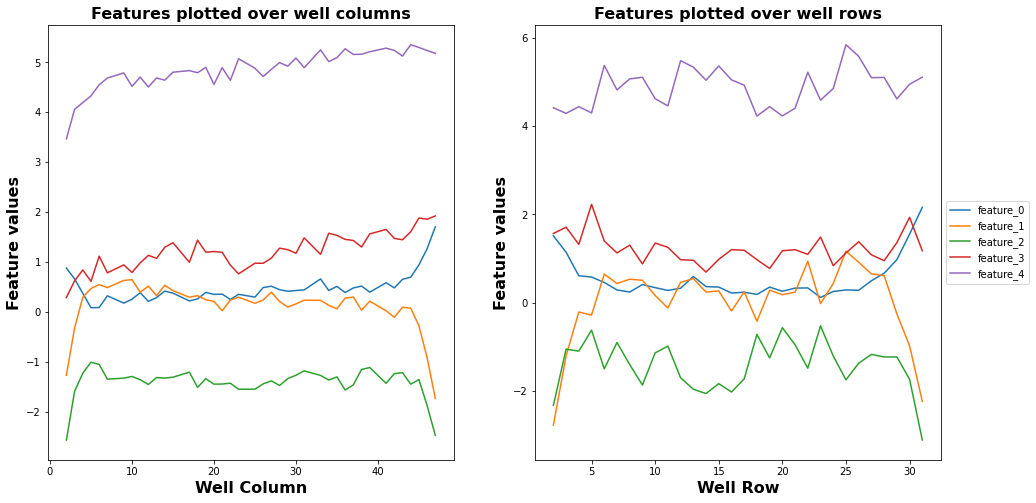

In [134]:
data = features_norm.join(metadata).loc[all_active]
data = data[data.experiment==exp].groupby(['well_row', 'well_col']).median().reset_index()
_,ax = plt.subplots(1,2,figsize=(16,8))

plt.sca(ax[0])
data.loc[:,['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'well_col']].groupby('well_col').median().plot.line(ax=ax[0]);
plt.xlabel('Well Column', fontdict={'weight': 'bold', 'size': 16});
plt.ylabel('Feature values', fontdict={'weight': 'bold', 'size': 16});
plt.title('Features plotted over well columns', fontdict={'weight': 'bold', 'size': 16});
ax[0].get_legend().remove()

plt.sca(ax[1])
data.loc[:,['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'well_row']].groupby('well_row').median().plot.line(ax=ax[1]);
plt.xlabel('Well Row', fontdict={'weight': 'bold', 'size': 16});
plt.ylabel('Feature values', fontdict={'weight': 'bold', 'size': 16});
plt.title('Features plotted over well rows', fontdict={'weight': 'bold', 'size': 16});
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5));

## Remove systematic row/column bias
- Apply the median polish using the overall median plate as a spatial bias template, which will help avoid random effects that exist on any one plate
- Median polish the negative controls separately since there is not column overlap with Active wells

In [135]:
# Do a median polish of column and row effects based on the medians over all plates within an experiment

features_mp = features_norm.copy()

max_iter = 2

for exp in metadata.experiment.unique():
  for group in [neg_ctrl, all_active]:
    curr = features_mp[(metadata.experiment == exp)].join(metadata[['well_col', 'well_row']])
    curr = curr.loc[curr.index.intersection(group)].set_index(['well_col', 'well_row'], append=True)
    
    overall_med = curr.median()

    for iter in range(max_iter-1):
      median_plate = curr.groupby(level=['well_col','well_row']).median()  
      col_meds = median_plate.groupby(level='well_col').median()
      col_diff = (col_meds - overall_med)[features.columns]
      
      curr = curr - col_diff

      median_plate = curr.groupby(level=['well_col','well_row']).median()
      row_meds = median_plate.groupby(level='well_row').median()
      row_diff = (row_meds - overall_med)[features.columns]

      curr = curr - row_diff
    
    curr = curr.droplevel(['well_col', 'well_row'])
    features_mp.loc[curr.index] = curr

## Recheck for spatial bias
- Since we are looking at the median over all plates, it makes sense that there is minimal/zero variation

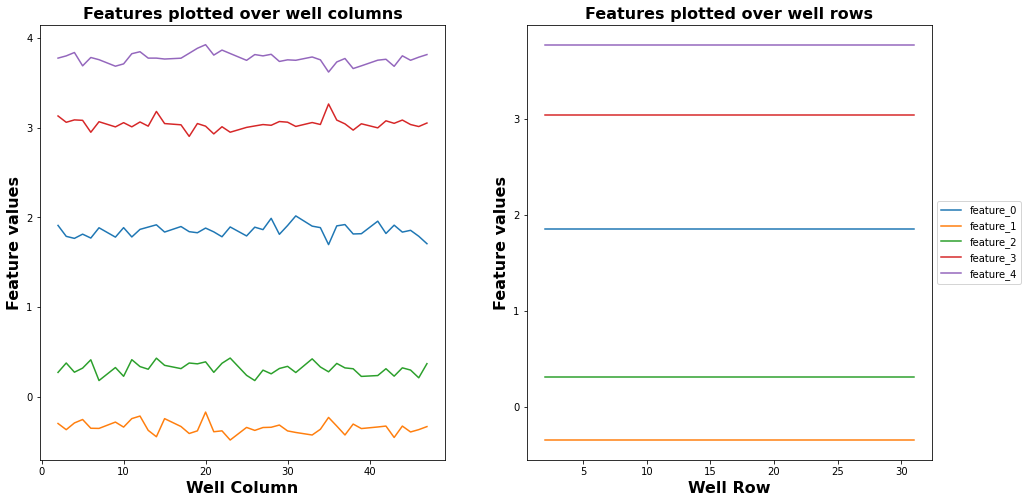

In [136]:
data = features_mp.join(metadata).loc[all_active]
data = data[data.experiment==exp].groupby(['well_row', 'well_col']).median().reset_index()
_,ax = plt.subplots(1,2,figsize=(16,8))

plt.sca(ax[0])
data.loc[:,['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'well_col']].groupby('well_col').median().plot.line(ax=ax[0]);
plt.xlabel('Well Column', fontdict={'weight': 'bold', 'size': 16});
plt.ylabel('Feature values', fontdict={'weight': 'bold', 'size': 16});
plt.title('Features plotted over well columns', fontdict={'weight': 'bold', 'size': 16});
ax[0].get_legend().remove()

plt.sca(ax[1])
data.loc[:,['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'well_row']].groupby('well_row').median().plot.line(ax=ax[1]);
plt.xlabel('Well Row', fontdict={'weight': 'bold', 'size': 16});
plt.ylabel('Feature values', fontdict={'weight': 'bold', 'size': 16});
plt.title('Features plotted over well rows', fontdict={'weight': 'bold', 'size': 16});
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5));

## Quantile normalization
- Within each sample, quantile transform the feature distribution

In [149]:
features_qn = features_mp.copy()

# Quantile transform the feature data within each sample - aim is to standardize the overall magnitude and distribution across features within each sample. 
qt = QuantileTransformer(n_quantiles=1000, output_distribution='normal', random_state=0)
features_qn = pd.DataFrame(np.transpose(qt.fit_transform(features_qn.T)), index=features_qn.index, columns=features_qn.columns)

# # Normalize the overall magnitude of each sample's feature vector (alternative to QN above)
# features_norm = features_norm.apply(lambda x: x/np.linalg.norm(x), axis=1)

# Standardize the Data before PCA


In [150]:
features_std = features_qn.copy()

# Standardize the data within each feature before PCA
#   For each experiment, treat the negative and positive control data as "training" data and the rest as "test" data 
for exp in metadata.experiment.unique():

  # Get index masks
  tx_idx = metadata.index.difference(main_ctrls) # rest of the samples
  exp_idx = metadata[metadata.experiment==exp].index # all samples in this experiment
  # Instantiate scaler
  scaler = StandardScaler()
  # Fit and transform based on the controls in this experiment
  features_std.loc[main_ctrls.intersection(exp_idx)] = scaler.fit_transform(features_std.loc[main_ctrls.intersection(exp_idx)])
  # Transform the remaining treatment groups in this experiment
  features_std.loc[tx_idx.intersection(exp_idx)] = scaler.transform(features_std.loc[tx_idx.intersection(exp_idx)])

# PCA

In [151]:
# Do PCA to reduce feature space and create orthogonal features

# Setup PCs dataframe with new column labels
pca_feats = features_std.copy()
PC_n = 500 # number of PCs 
PC_cols = [''.join(tup) for tup in list(zip(['PC']*PC_n, [str(x) for x in range(1, PC_n+1)]))] # Make list of PC# columns labels
pca_feats = pca_feats.iloc[:, :PC_n]
pca_feats.rename(dict(zip(features.columns, PC_cols)), axis=1, inplace=True)

pca_idx = 0 # initial index of PCs to keep - update in for loop

# Do PCA separately for each experiment
for exp in metadata.experiment.unique():

  # Get index masks
  tx_idx = metadata.index.difference(main_ctrls)
  exp_idx = metadata[metadata.experiment==exp].index

  # Instantiate PCA model
  pca = PCA(whiten=True, n_components=PC_n, svd_solver='full')

  # Fit and transform based on the controls in this experiment
  pca_feats.loc[main_ctrls.intersection(exp_idx)] = pca.fit_transform(pca_feats.loc[main_ctrls.intersection(exp_idx)])
  
  # Transform the remaining groups in this experiment
  pca_feats.loc[tx_idx.intersection(exp_idx)] = pca.transform(pca_feats.loc[tx_idx.intersection(exp_idx)])

  # Determine how many PCs to keep based on threshold of overall variance explained
  thresh = 0.99
  curr_pca_idx = pd.Series(pca.explained_variance_ratio_).cumsum().sub(thresh).abs().idxmin()
  # Just use the max number of PCs needed to explain at least thresh% variance across each experiment
  if curr_pca_idx > pca_idx:
    pca_idx = curr_pca_idx 

# Filter the PCs to keep
print('PCs kept:', pca_idx)
PC_2_keep = PC_cols[:pca_idx]
pca_feats = pca_feats[PC_2_keep]

PCs kept: 309


# Remove Outliers

In [152]:
# Remove outliers within each control group based on Mahalanobis distance and cosine similarity

pca_final = pca_feats.copy()

for exp in metadata.experiment.unique():
  for ctrl in [neg_ctrl, pos_ctrl]:

    idx_mask = metadata[metadata.experiment==exp].index.intersection(ctrl)  
    curr = pca_final.loc[idx_mask] # current ctrl and experiment

    # Calculate covariance matrices
    cov_mat = curr.cov()
    # Calculate inverse cov mat
    inv_cov = np.linalg.pinv(cov_mat)
    # Caluclate PC means
    feat_means = curr.mean()    
    # Instantiate mahal lambda funcs
    mahal_lam = lambda x: spatial.distance.mahalanobis(x, feat_means, inv_cov)
    # Calculate mahalanobis distance
    mahalD = curr.apply(mahal_lam, axis=1)
    # Calculate cutoff to define outliers
    Q1 = mahalD.quantile(0.25)
    Q3 = mahalD.quantile(0.75)
    IQR = Q3 - Q1
    cutoff = Q3 + 1.5*IQR     
    outliers_mahal = mahalD[mahalD > cutoff].index


    ## Cosine Similarity
    # Median control vector
    curr_med = curr.median()

    # Cosine similarity of each sample to the median
    cos_sim_func = lambda x: spatial.distance.cosine(curr_med, x)
    cos_sim = curr.apply(cos_sim_func, axis=1)

    # Calculate cutoff to define outliers
    Q1 = cos_sim.quantile(0.25)
    Q3 = cos_sim.quantile(0.75)
    IQR = Q3 - Q1
    cutoff_hi = Q3 + 1.5*IQR
    cutoff_lo = Q1 - 1.5*IQR      
    outliers_cos = cos_sim[(cos_sim > cutoff_hi) | (cos_sim < cutoff_lo)].index

    # Drop outliers
    outliers = outliers_cos.union(outliers_mahal)
    print('Outliers dropped for {}, {}: {:.2}%'.format(exp, metadata.loc[idx_mask].disease_condition.unique()[0], len(outliers)/len(curr)*100))
    pca_final = pca_final.drop(outliers, axis=0)
    

Outliers dropped for HRCE-1, Mock: 2.9%
Outliers dropped for HRCE-1, Active: 3.0%
Outliers dropped for HRCE-2, Mock: 1.4%
Outliers dropped for HRCE-2, Active: 2.6%


# Fit Classifier and Create Disease Axis

In [153]:
# Fit Classifier
# model = LogisticRegression(C=0.003, max_iter=10000)
model = LinearDiscriminantAnalysis() # Deafult LDA yields similar results to LR with regularization

# Initialize dataframes to contain results of interest
disease_scores = pd.DataFrame(index=pca_final.index, columns = ['on_disease_score', 'off_disease_score'] + list(metadata.columns))
Zfactor = pd.Series(index=list(metadata.experiment.unique()) + ['Overall'], dtype=float)

# Create separately for each experiment - correct for batch effect by normalizing scores between 0 and 1
for exp in metadata.experiment.unique():

  # Just use the positive and negative controls to train the classifier and then use treatment data as "test" data
  idx_mask = metadata[metadata.experiment==exp].index.intersection(pca_final.index) # current experiment and data without outliers
  curr_data = pca_final.loc[idx_mask]
  ctrl_data = pca_final.loc[main_ctrls.intersection(idx_mask)] 
  tx_data = pca_final.loc[idx_mask.difference(ctrl_data.index)]

  # Define the first experiment as the training set and the 2nd as the test set
  X_train = ctrl_data
  y_train = (metadata.loc[X_train.index].disease_condition == 'Active').astype(int)
  X_test = tx_data
  
  # Fit the model and get the coeficients
  model.fit(X_train, y_train)
  print('{} Classification Accuracy: {:.3f}'.format(exp, model.score(X_train, y_train)))
  weights = model.coef_
  weights_norm = weights/np.linalg.norm(weights)
  
  # Define the disease axis as the weights from logistic regression (dot product with these weights = decision function)
  dis_vec = pd.Series(np.ravel(weights_norm), index=curr_data.columns)

  # Calculate on-disease score based on scalar projection of each well's features onto the disease axis (dis_vec)
  on_disease_score = curr_data.dot(dis_vec) # scalar projection (decision function)

  # Use Pythagorean theorem to calculate off-disease score
  off_disease_score = (curr_data.apply(np.linalg.norm, axis=1)**2 - on_disease_score**2).apply(np.sqrt)

  # Setup disease scores 
  on_disease_score.rename('on_disease_score', inplace=True)
  off_disease_score.rename('off_disease_score', inplace=True)
  curr_scores = pd.concat([on_disease_score, off_disease_score], axis=1)

  # Normalize the scores to mean=0 for neg control and mean=1 for pos control
  mean_pos = curr_scores.loc[curr_data.index.intersection(pos_ctrl)].mean()
  mean_neg = curr_scores.loc[curr_data.index.intersection(neg_ctrl)].mean()
  curr_scores['on_disease_score'] = curr_scores['on_disease_score'].apply(lambda x: (x - mean_neg.on_disease_score) / (mean_pos.on_disease_score - mean_neg.on_disease_score))
  curr_scores['off_disease_score'] = curr_scores['off_disease_score'].apply(lambda x: (x - mean_neg.off_disease_score) / (mean_pos.off_disease_score - mean_neg.off_disease_score))

  # Calculate the Z-factor based on the on-disease score
  sd_pos = curr_scores.loc[curr_data.index.intersection(pos_ctrl)].on_disease_score.std()
  sd_neg = curr_scores.loc[curr_data.index.intersection(neg_ctrl)].on_disease_score.std()
  mean_pos = curr_scores.loc[curr_data.index.intersection(pos_ctrl)].on_disease_score.mean() # need to recalculate means after transform
  mean_neg = curr_scores.loc[curr_data.index.intersection(neg_ctrl)].on_disease_score.mean()
  Zfactor.loc[exp] = 1 - 3*(sd_neg + sd_pos)/np.abs(mean_pos - mean_neg)

  # Update the disease scores dataframe
  disease_scores.loc[curr_data.index] = curr_scores.join(metadata)

# Calculate the overall Z-factor across experiments (assuming poolability)
sd_pos = disease_scores.loc[disease_scores.index.intersection(pos_ctrl)].on_disease_score.std()
sd_neg = disease_scores.loc[disease_scores.index.intersection(neg_ctrl)].on_disease_score.std()
mean_pos = disease_scores.loc[disease_scores.index.intersection(pos_ctrl)].on_disease_score.mean()
mean_neg = disease_scores.loc[disease_scores.index.intersection(neg_ctrl)].on_disease_score.mean()
Zfactor.loc['Overall'] = 1 - 3*(sd_neg + sd_pos)/np.abs(mean_pos - mean_neg)

HRCE-1 Classification Accuracy: 0.999
HRCE-2 Classification Accuracy: 0.999


# Evaluate the Disease Model

## Overlay of disease axes for both experiments

Z-factors for each experiment:
HRCE-1: 0.350
HRCE-2: 0.336
Overall: 0.344


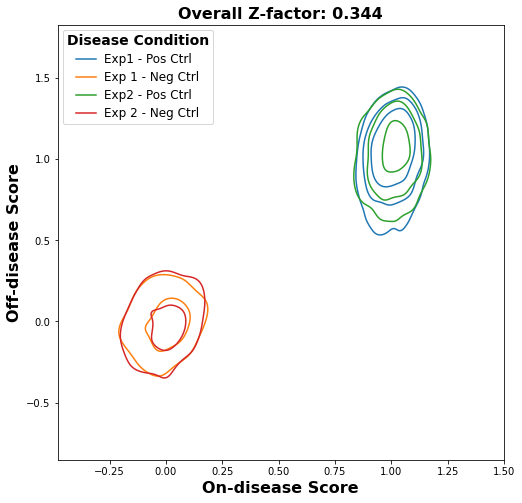

In [154]:
# Plot the controls and experiments to qualitatively examine agreement between experiments
plt.figure(figsize=(8,8));
ctrl_mask = main_ctrls.intersection(disease_scores.index)
print('Z-factors for each experiment:')
for ii in range(len(Zfactor)):
  print('{}: {:.3f}'.format(Zfactor.index[ii], Zfactor[ii]))
fig = sns.kdeplot(x='on_disease_score', y='off_disease_score', data=disease_scores.loc[ctrl_mask], hue=disease_scores.loc[ctrl_mask][['experiment', 'disease_condition']].apply(tuple, axis=1), levels=[0.25, 0.5, 0.75]);
plt.xlabel('On-disease Score', fontdict={'weight': 'bold', 'size': 16});
plt.xticks(np.arange(-0.25, 1.75, 0.25));
plt.ylabel('Off-disease Score', fontdict={'weight': 'bold', 'size': 16});
plt.title('Overall Z-factor: {:.3f}'.format(Zfactor.loc['Overall']), fontdict={'weight': 'bold', 'size': 16});

sns.move_legend(fig, loc='upper left')

# Update legend
lgnd = fig.get_legend()
lgnd.set_title('Disease Condition');
new_labels = ['Exp1 - Pos Ctrl', 'Exp 1 - Neg Ctrl', 'Exp2 - Pos Ctrl', 'Exp 2 - Neg Ctrl']
for t, l in zip(lgnd.texts, new_labels):
    t.set_text(l);
plt.setp(lgnd.get_texts(), fontsize='12');
plt.setp(lgnd.get_title(), fontsize='14', fontweight='bold');

## Pooled Disease Model

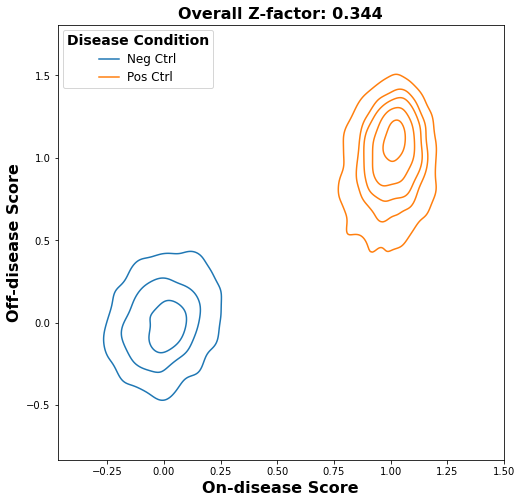

In [155]:
# Overlap looks good above, plot the two experiments together (assumes batch effects sufficiently removed)
plt.figure(figsize=(8,8));
ctrl_mask = main_ctrls.intersection(disease_scores.index)
fig = sns.kdeplot(x='on_disease_score', y='off_disease_score', data=disease_scores.loc[ctrl_mask], hue='disease_condition', levels=[0.1, 0.3, 0.5, 0.7, 0.9], hue_order=['Mock', 'Active'], legend=True);
plt.xlabel('On-disease Score', fontdict={'weight': 'bold', 'size': 16});
plt.xticks(np.arange(-0.25, 1.75, 0.25));
plt.ylabel('Off-disease Score', fontdict={'weight': 'bold', 'size': 16});
plt.title('Overall Z-factor: {:.3f}'.format(Zfactor.loc['Overall']), fontdict={'weight': 'bold', 'size': 16});

sns.move_legend(fig, loc='upper left')

# Update legend
lgnd = fig.get_legend()
lgnd.set_title('Disease Condition');
new_labels = ['Neg Ctrl', 'Pos Ctrl']
for t, l in zip(lgnd.texts, new_labels):
    t.set_text(l);
plt.setp(lgnd.get_texts(), fontsize='12');
plt.setp(lgnd.get_title(), fontsize='14', fontweight='bold');
    

## Distributions of On-disease scores for each experiment

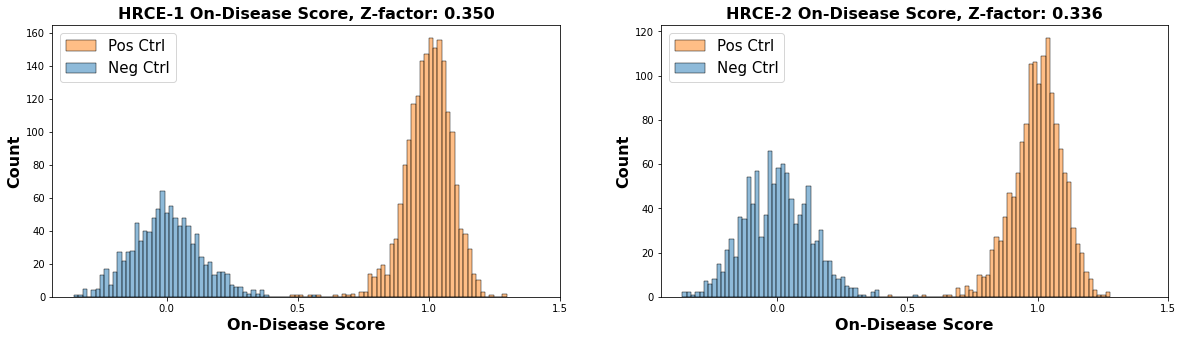

In [156]:
# Plot the on-disease and off-disease scores for each control, separately for the two experiments
fig, ax = plt.subplots(1,2, figsize=(20,5))
plt.sca(ax[0])
data = disease_scores.loc[ctrl_mask]
sns.histplot(data=data[data.experiment=='HRCE-1'], x='on_disease_score', hue='disease_condition', bins=100, hue_order=['Mock', 'Active']);
plt.title('HRCE-1 On-Disease Score, Z-factor: {:.3f}'.format(Zfactor['HRCE-1']), fontdict={'weight': 'bold', 'size': 16});
plt.xlabel('On-Disease Score', fontdict={'weight': 'bold', 'size': 16});
plt.ylabel('Count', fontdict={'weight': 'bold', 'size': 16})
plt.xticks([0, 0.5, 1, 1.5]);
plt.legend(['Pos Ctrl', 'Neg Ctrl'], prop={'size':15});

plt.sca(ax[1])
sns.histplot(data=data[data.experiment=='HRCE-2'], x='on_disease_score', hue='disease_condition', bins=100, hue_order=['Mock', 'Active']);
plt.title('HRCE-2 On-Disease Score, Z-factor: {:.3f}'.format(Zfactor['HRCE-2']), fontdict={'weight': 'bold', 'size': 16});
plt.xlabel('On-Disease Score', fontdict={'weight': 'bold', 'size': 16});
plt.ylabel('Count', fontdict={'weight': 'bold', 'size': 16})
plt.xticks([0, 0.5, 1, 1.5]);
plt.legend(['Pos Ctrl', 'Neg Ctrl'], prop={'size':15});

# Comparison of consistency across experiments

## Experiment 1 vs. Experiment 2

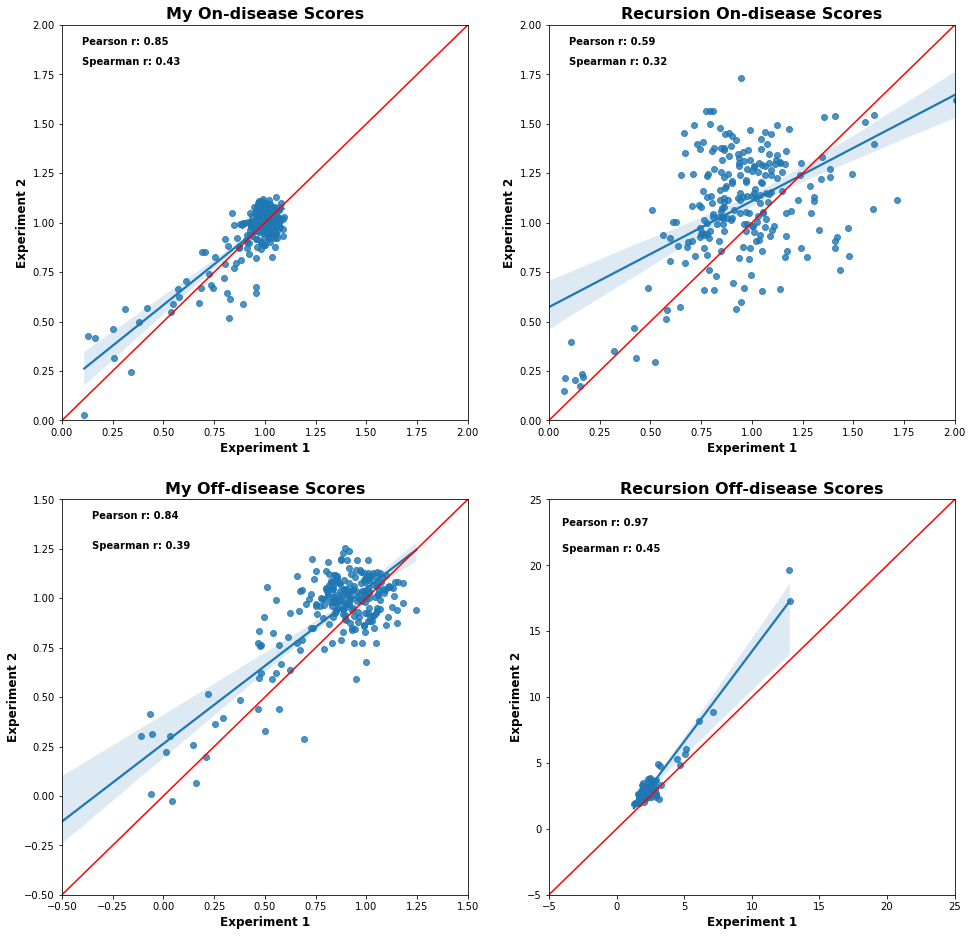

In [157]:
# Import Recursion's results data
rx_disease_scores = pd.read_csv('/Volumes/GoogleDrive/My Drive/Colab Notebooks/Recursion COVID/COVID_disease_scores.csv')
rx_disease_scores.replace({'COVID19-launchedp1-HRCE-X-b-20x': 'HRCE-1', 'COVID19-launchedp2-HRCE-X-b-20x': 'HRCE-2'}, inplace=True)
rx_disease_scores = rx_disease_scores[(rx_disease_scores.experiment!='COVID19-reference-VERO-48-a-20x') & (rx_disease_scores.experiment!='COVID19-reference-VERO-48-b-20x')]
rx_hit_scores = pd.read_csv('/Volumes/GoogleDrive/My Drive/Colab Notebooks/Recursion COVID/COVID_hit_scores.csv')
rx_hit_scores.replace({'COVID19-launchedp1-HRCE-X-b-20x': 'HRCE-1', 'COVID19-launchedp2-HRCE-X-b-20x': 'HRCE-2'}, inplace=True)
rx_hit_scores = rx_hit_scores[(rx_hit_scores.experiment!='COVID19-reference-VERO-48-a-20x') & (rx_hit_scores.experiment!='COVID19-reference-VERO-48-b-20x')]

# Plot the scores from the two experiments against each other to examine correlation
# Compare correlations in Recursion's data and my data

summary = disease_scores.groupby(['experiment', 'treatment', 'treatment_conc'])[['on_disease_score', 'off_disease_score']].median()
data = summary.loc['HRCE-1'].join(summary.loc['HRCE-2'], rsuffix='_2', how='inner')
rx_summary = rx_disease_scores.groupby(['experiment', 'treatment', 'treatment_conc'])[['on_disease_score', 'off_disease_score']].median()
data_rx = rx_summary.loc['HRCE-1'].join(rx_summary.loc['HRCE-2'], rsuffix='_2', how='inner')
data_rx.dropna(axis=0, inplace=True)

_, ax = plt.subplots(2,2, figsize=(16,16))

pear_r, _ = stats.pearsonr(data.on_disease_score, data.on_disease_score_2)
spear_r, _ = stats.spearmanr(data.on_disease_score, data.on_disease_score_2)

plt.sca(ax[0,0])
sns.regplot(x='on_disease_score', y='on_disease_score_2', data=data)
plt.ylim(0, 2);
plt.xlim(0, 2);
plt.plot([-0.5, 3], [-0.5, 3], 'r-');
plt.text(.1, 1.9, 'Pearson r: {:.2f}'.format(pear_r), fontdict={'weight':'bold'});
plt.text(.1, 1.8, 'Spearman r: {:.2f}'.format(spear_r), fontdict={'weight':'bold'});
plt.title('My On-disease Scores', fontdict={'weight':'bold', 'size':16});
plt.xlabel('Experiment 1', fontdict={'weight':'bold', 'size':12});
plt.ylabel('Experiment 2', fontdict={'weight':'bold', 'size':12});

pear_r, _ = stats.pearsonr(data_rx.on_disease_score, data_rx.on_disease_score_2)
spear_r, _ = stats.spearmanr(data_rx.on_disease_score, data_rx.on_disease_score_2)

plt.sca(ax[0,1])
sns.regplot(x='on_disease_score', y='on_disease_score_2', data=data_rx)
plt.ylim(0, 2);
plt.xlim(0, 2);
plt.plot([-0.5, 3], [-0.5, 3], 'r-');
plt.text(.1, 1.9, 'Pearson r: {:.2f}'.format(pear_r), fontdict={'weight':'bold'});
plt.text(.1, 1.8, 'Spearman r: {:.2f}'.format(spear_r), fontdict={'weight':'bold'});
plt.title('Recursion On-disease Scores', fontdict={'weight':'bold', 'size':16});
plt.xlabel('Experiment 1', fontdict={'weight':'bold', 'size':12});
plt.ylabel('Experiment 2', fontdict={'weight':'bold', 'size':12});

pear_r, _ = stats.pearsonr(data.off_disease_score, data.off_disease_score_2)
spear_r, _ = stats.spearmanr(data.off_disease_score, data.off_disease_score_2)

plt.sca(ax[1,0])
sns.regplot(x='off_disease_score', y='off_disease_score_2', data=data)
plt.ylim(-.5, 1.5);
plt.xlim(-.5, 1.5);
plt.plot([-15, 200], [-15, 200], 'r-');
plt.text(-.35, 1.4, 'Pearson r: {:.2f}'.format(pear_r), fontdict={'weight':'bold'});
plt.text(-.35, 1.25, 'Spearman r: {:.2f}'.format(spear_r), fontdict={'weight':'bold'});
plt.title('My Off-disease Scores', fontdict={'weight':'bold', 'size':16});
plt.xlabel('Experiment 1', fontdict={'weight':'bold', 'size':12});
plt.ylabel('Experiment 2', fontdict={'weight':'bold', 'size':12});

pear_r, _ = stats.pearsonr(data_rx.off_disease_score, data_rx.off_disease_score_2)
spear_r, _ = stats.spearmanr(data_rx.off_disease_score, data_rx.off_disease_score_2)

plt.sca(ax[1,1])
sns.regplot(x='off_disease_score', y='off_disease_score_2', data=data_rx)
plt.ylim(-5, 25);
plt.xlim(-5, 25);
plt.plot([-10, 100], [-10, 100], 'r-');
plt.text(-4, 23, 'Pearson r: {:.2f}'.format(pear_r), fontdict={'weight':'bold'});
plt.text(-4, 21, 'Spearman r: {:.2f}'.format(spear_r), fontdict={'weight':'bold'});
plt.title('Recursion Off-disease Scores', fontdict={'weight':'bold', 'size':16});
plt.xlabel('Experiment 1', fontdict={'weight':'bold', 'size':12});
plt.ylabel('Experiment 2', fontdict={'weight':'bold', 'size':12});


### Mean-Difference plots between the 2 experiments

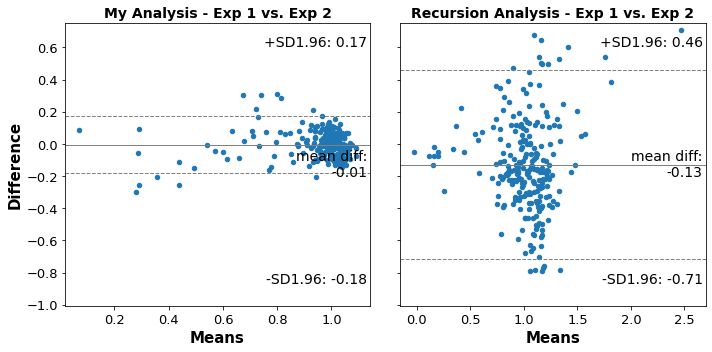

In [158]:
# Use mean-difference plots to examine agreement between the replicated HRCE experiments
data = summary.loc['HRCE-1'].join(summary.loc['HRCE-2'], rsuffix='_2')
data_rx = rx_summary.loc['HRCE-1'].join(rx_summary.loc['HRCE-2'], rsuffix='_2', how='inner')
_, ax = plt.subplots(1,2, figsize=(10,5), sharey=True)

sm.graphics.mean_diff_plot(data.on_disease_score, data.on_disease_score_2, ax=ax[0])
plt.sca(ax[0])
plt.title('My Analysis - Exp 1 vs. Exp 2', fontdict={'weight': 'bold', 'size':14});
plt.xlabel('Means', fontdict={'weight': 'bold'});
plt.ylabel('Difference', fontdict={'weight': 'bold'});

sm.graphics.mean_diff_plot(data_rx.on_disease_score, data_rx.on_disease_score_2, ax=ax[1])
plt.sca(ax[1])
plt.title('Recursion Analysis - Exp 1 vs. Exp 2', fontdict={'weight': 'bold', 'size':14});
plt.xlabel('Means', fontdict={'weight': 'bold'});
plt.ylabel('');

# Evaluation of Drug Candidates

## Key treatments that were in both experiments

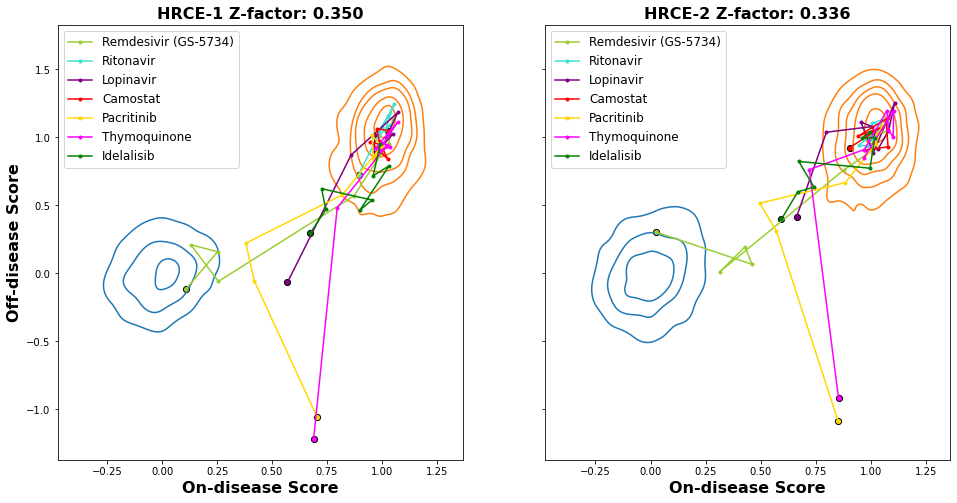

In [159]:
treatments = ['Remdesivir (GS-5734)', 'Ritonavir', 'Lopinavir', 'Camostat', 'Pacritinib', 'Thymoquinone', 'Idelalisib']
colors = ['yellowgreen', 'turquoise', 'purple', 'red', 'gold', 'magenta', 'green']

_, ax = plt.subplots(1,2, figsize=(16,8), sharey=True);

for ii, exp in enumerate(['HRCE-1', 'HRCE-2']):

  plt.sca(ax[ii])
  ctrl_mask = main_ctrls.intersection(disease_scores.index)
  exp1_ctrl = disease_scores[disease_scores.experiment == exp].index.intersection(ctrl_mask)
  fig = sns.kdeplot(x='on_disease_score', y='off_disease_score', data=disease_scores.loc[exp1_ctrl], hue='disease_condition', levels=[0.1, 0.3, 0.5, 0.7, 0.9], hue_order=['Mock', 'Active']);
  plt.xlabel('On-disease Score', fontdict={'weight': 'bold', 'size': 16});
  plt.xticks(np.arange(-0.25, 1.75, 0.25));
  plt.ylabel('Off-disease Score', fontdict={'weight': 'bold', 'size': 16});
  plt.title('{} Z-factor: {:.3f}'.format(exp, Zfactor.loc[exp]), fontdict={'weight': 'bold', 'size': 16});

  # Plot each of the treatments and associated colors listed above
  for c, tx in zip(colors, treatments):

    data = summary.loc[(exp, tx)]
    plt.plot(data.on_disease_score, data.off_disease_score, '.-', c=c, label=tx)
    plt.scatter(data.on_disease_score.iloc[-1], data.off_disease_score.iloc[-1], c=c, marker='.', s=150, edgecolor='black', linewidth=1)
  
  plt.legend(prop={'size':12});

## Plot the dose-response curves for Remdesivir

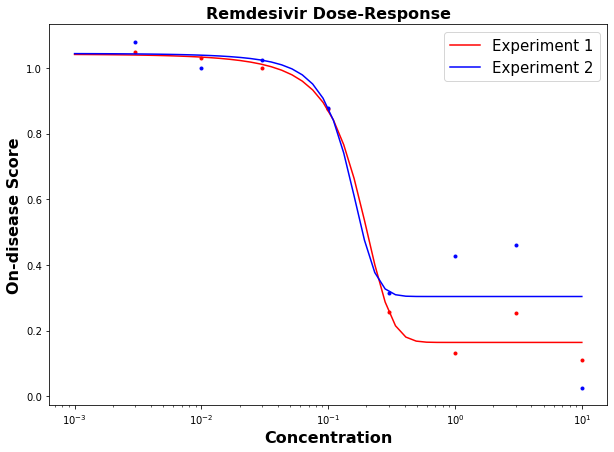

In [160]:
plt.figure(figsize=(10,7))

# Plot the data points
data1 = summary.loc[('HRCE-1', 'Remdesivir (GS-5734)')]
plt.scatter(data1.index, data1.on_disease_score, marker='.', c='r', label='Remdesivir-1')
data2 = summary.loc[('HRCE-2', 'Remdesivir (GS-5734)')]
plt.scatter(data2.index, data2.on_disease_score, marker='.', c='b', label='Remdesivir-2')
plt.xscale('log');
plt.ylabel('On-disease Score');
plt.xlabel('Concentration');
plt.legend();

# Fit to a generalized sigmoid function
def sigmoid(x, k, L, b, c):
  y = k / (L + np.exp(-(b*x))) + c
  return (y)

# Fit and plot the data from each experiment
coeffs1, _ = curve_fit(sigmoid, data1.index, data1.on_disease_score)  
y_pred1 = sigmoid(np.logspace(-3, 1, 50), *coeffs1)
plt.plot(np.logspace(-3, 1, 50), y_pred1, 'r');

coeffs2, _ = curve_fit(sigmoid, data2.index, data2.on_disease_score)  
y_pred2 = sigmoid(np.logspace(-3, 1, 50), *coeffs2)
plt.plot(np.logspace(-3, 1, 50), y_pred2, 'b');
;
plt.title('Remdesivir Dose-Response', fontdict={'weight':'bold', 'size':16});
plt.xlabel('Concentration', fontdict={'weight':'bold', 'size':16});
plt.ylabel('On-disease Score', fontdict={'weight':'bold', 'size':16});
plt.legend(['Experiment 1', 'Experiment 2'], prop={'size':15});